# У нас есть еще один вопрос, на который нужно ответить: когда наши пользователи обычно выполняют лабораторные работы: ночью, утром, днем ​​или вечером? И как это изменилось со временем?

In [13]:
import pandas as pd
import sqlite3


conn = sqlite3.connect('../data/checking-logs.sqlite')

In [14]:
commits_query = """
SELECT timestamp
FROM checker
WHERE uid LIKE 'user_%';
"""
commits_df = pd.read_sql_query(commits_query, conn)

# Преобразование столбца timestamp в формат datetime
commits_df['timestamp'] = pd.to_datetime(commits_df['timestamp'])


In [15]:
def get_time_of_day(hour):
    if 0 <= hour < 4:
        return 'night'
    elif 4 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 17:
        return 'afternoon'
    else:
        return 'evening'

# Добавление столбца с временем суток
commits_df['time_of_day'] = commits_df['timestamp'].dt.hour.apply(get_time_of_day)

# Группировка данных по дате и времени суток
commits_per_day_and_time = commits_df.groupby([commits_df['timestamp'].dt.date, 'time_of_day']).size().reset_index(name='count')

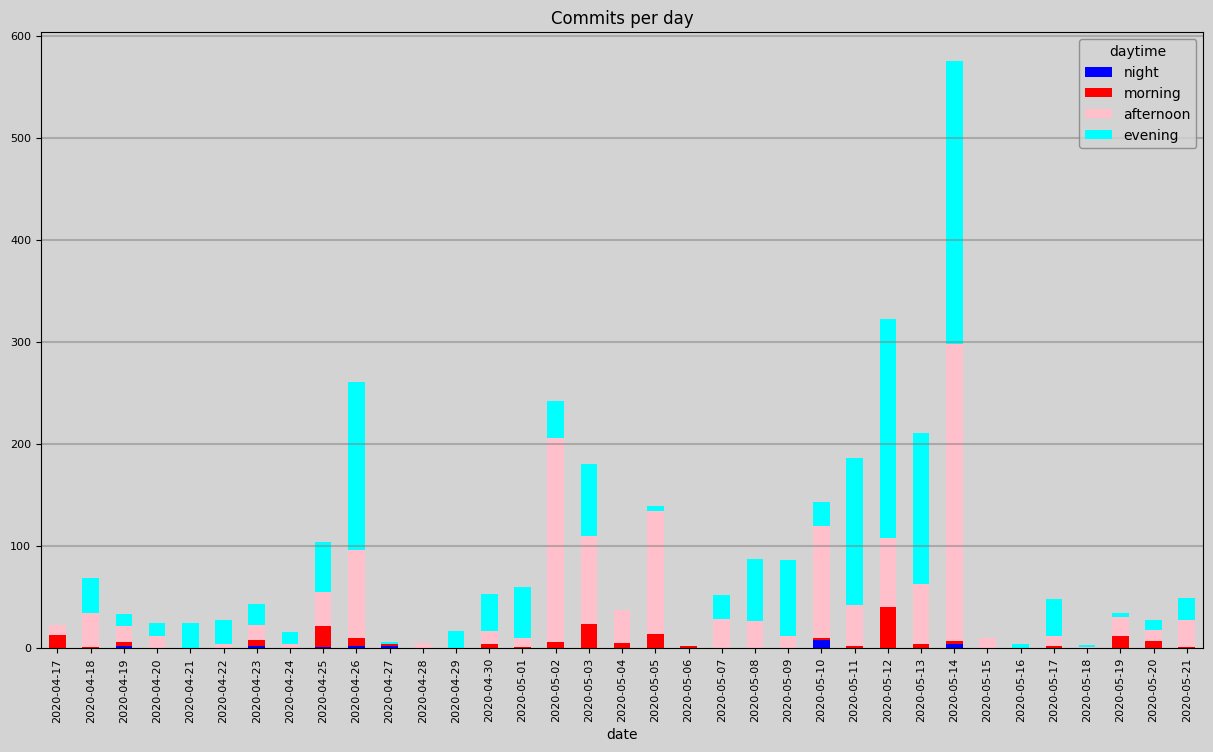

In [16]:
# Преобразование данных для построения графика
pivot_df = commits_per_day_and_time.pivot(index='timestamp', columns='time_of_day', values='count').fillna(0)

# Указание порядка столбцов
pivot_df = pivot_df[['night', 'morning', 'afternoon', 'evening']]

# Построение графика
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 8),
    title='Commits per day',
    fontsize=8,
    color={
        'night': 'blue',  
        'morning': 'red',  
        'afternoon': 'pink',  
        'evening': 'cyan'   
    }
)

# Настройка осей
ax.set_xlabel('date')
ax.figure.set_facecolor('lightgray')
ax.set_facecolor('lightgrey')
ax.xaxis.set_tick_params(rotation=90)
ax.yaxis.set_tick_params(labelsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.legend(title='daytime', facecolor='lightgrey', edgecolor='grey')

# Добавление горизонтальных полос для указанных сумм коммитов
specific_commits = [100, 200, 300, 400, 500, 600]

for comm in specific_commits:
    ax.axhline(y=comm, color='gray', linestyle='-', alpha=0.5)

In [17]:
# Найти два наиболее распространенных периода
total_counts = commits_per_day_and_time.groupby('time_of_day')['count'].sum().reset_index()
most_common_times = total_counts.nlargest(2, 'count')

# Найти дату с наибольшим количеством коммитов и большим количеством коммитов вечером, чем днем
evening_commits_df = commits_df[commits_df['time_of_day'] == 'evening']
evening_commits_per_day = evening_commits_df.groupby(evening_commits_df['timestamp'].dt.date).size().reset_index(name='count')

max_evening_commits_day = pivot_df.loc[(pivot_df['evening'] > pivot_df['afternoon']), 'evening'].idxmax()

print(f"Два наиболее распространенных периода: {most_common_times['time_of_day'].values}")
print(f"\nДата с наибольшим количеством коммитов и большим количеством коммитов вечером, чем днем: {max_evening_commits_day}")

Два наиболее распространенных периода: ['evening' 'afternoon']

Дата с наибольшим количеством коммитов и большим количеством коммитов вечером, чем днем: 2020-05-12


In [18]:
conn.close()